In [1]:
import os
import glob
from re import sub
from ete3 import Tree, TreeStyle, AttrFace, TextFace, RectFace
import pandas as pd
from collections import defaultdict
import sss
from Bio import SeqIO
from io import StringIO
import dendropy
from datetime import datetime
from collections import defaultdict
import matplotlib as mpt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.patches import Ellipse
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# Read metadata and group infomation

In [4]:
# read all strains between 2019-12-30 to 2020-09-30
all_acc_after_2020 = pd.read_csv('data/isl_info_after2020.csv', sep='\t', index_col=0).index.tolist()
# read aiv database metainfo
AIV_INFO = pd.read_csv('data/00_original_data/all_aiv_info.csv', sep='\t', index_col=0)
# read genotype info
genotype = pd.read_csv('genotype.csv', sep='\t', index_col=9)
acc_with_full_genome = genotype.index.tolist()

In [5]:
domain_group = ['1_1_1_1_1_1_1_1', '0_0_0_0_0_0_0_0']
domain_group2 = ['1_1_1_1_1_1_1_1', '0_0_0_0_0_0_0_0', '4_2_3_0_3_2_0_0', '2_2_1_1_2_1_1_1', '3_2_2_1_2_1_1_2', '1_1_1_1_2_1_1_1']
seg_l = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'NS', 'MP']

accOfDomainGroup = {group: genotype[genotype['group'] == group].index.to_list() for group in domain_group}

# Parse tree of blast result

In [6]:
def parse_blast_tree(SEGMENT):  
    tree_file = f'data/07_blast_res/blast_res_{SEGMENT}.tree'
    tree = Tree(tree_file, format=0, quoted_node_names=True)

    mid_node = tree.get_midpoint_outgroup()
    tree.set_outgroup(mid_node)
    tree.ladderize(1)

    # annotate leaf node|
    for leaf in tree.iter_leaves():
        seq_acc, attr = leaf.name.split(' ', 1)
        isl_name, isl_acc, date, seg_name = attr.split('#')
        leaf.name = isl_acc
        subtype = AIV_INFO.loc[isl_acc, 'Subtype']
        leaf.add_features(isl_name=isl_name, date=date, seg_name=seg_name, subtype=subtype)
        try:
            group = genotype.loc[isl_acc, 'group']
            leaf.add_feature('group', group)
        except KeyError:
            leaf.add_feature('group', 'na')
    return tree


def extract_outgroup_for_intrest_group(SEGMENT):
    tree = parse_blast_tree(SEGMENT)

    print(f"****************************** {SEGMENT} ****************")
    for group, acc_l in accOfDomainGroup.items():
        acc_filter = [leaf for leaf in tree.iter_leaves() if leaf.name in acc_l]
        mrca = tree.get_common_ancestor(acc_filter)
        sis = mrca.get_sisters()

        print(f'For clade {group}:')
        print('Sister clade:')
        for leaf in sis[0].iter_leaves():
            print('\t', leaf.name, leaf.subtype, leaf.date, leaf.isl_name, sep='\t')
        print('Outgroup clade')
        sis_up = mrca.up.get_sisters()[0]
        for leaf in sis_up.iter_leaves():
            print('\t', leaf.name, leaf.subtype, leaf.date, leaf.isl_name, sep='\t')
        print()

In [7]:
seg_l = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']
# for seg in seg_l:
#     extract_outgroup_for_intrest_group(seg)

# visualiztion blast tree with group info

In [8]:
def layout2(node):
    node.img_style['size'] = 0
    # node.add_face(AttrFace('name', fsize=6), 0, 'branch-right')
    if node.is_leaf():
        node.add_face(AttrFace('isl_name', fsize=6, text_prefix=' ', text_suffix=' '), 0, 'branch-right')
        node.add_face(AttrFace('subtype', fsize=6, text_prefix=' ', text_suffix=' '), 0, 'aligned')
        node.add_face(AttrFace('date', fsize=6, text_prefix=' ', text_suffix=' '), 1, 'aligned')

        # color strains from 2020-2021 epidemic with green
        if node.name in all_acc_after_2020:
            node.img_style['size'] = 4
            node.img_style['fgcolor'] = 'green'
            node.img_style['vt_line_color'] = 'green'
            node.img_style['hz_line_color'] = 'green'

        # annotate strain with group information
        if node.name in acc_with_full_genome:
            node.add_face(AttrFace('group', fsize=6, text_prefix=' ', text_suffix=' '), 2, 'aligned')

        # color strains not H5N8 with red
        if node.subtype != 'A / H5N8':
            node.img_style['size'] = 4
            node.img_style['fgcolor'] = 'red'
            node.img_style['vt_line_color'] = 'red'
            node.img_style['hz_line_color'] = 'red'



In [28]:
tree = parse_blast_tree('HA')

In [50]:
acc_in_tree = [l.name for l in tree.get_leaves()]
cond = AIV_INFO.Location.str.split(' / ').str.get(1) == "South Africa"
cond2 = AIV_INFO.Collection_Date > '2017'
acc_southafrica = AIV_INFO[cond & cond2 & (AIV_INFO.Subtype == "A / H5N8")].index.to_list()

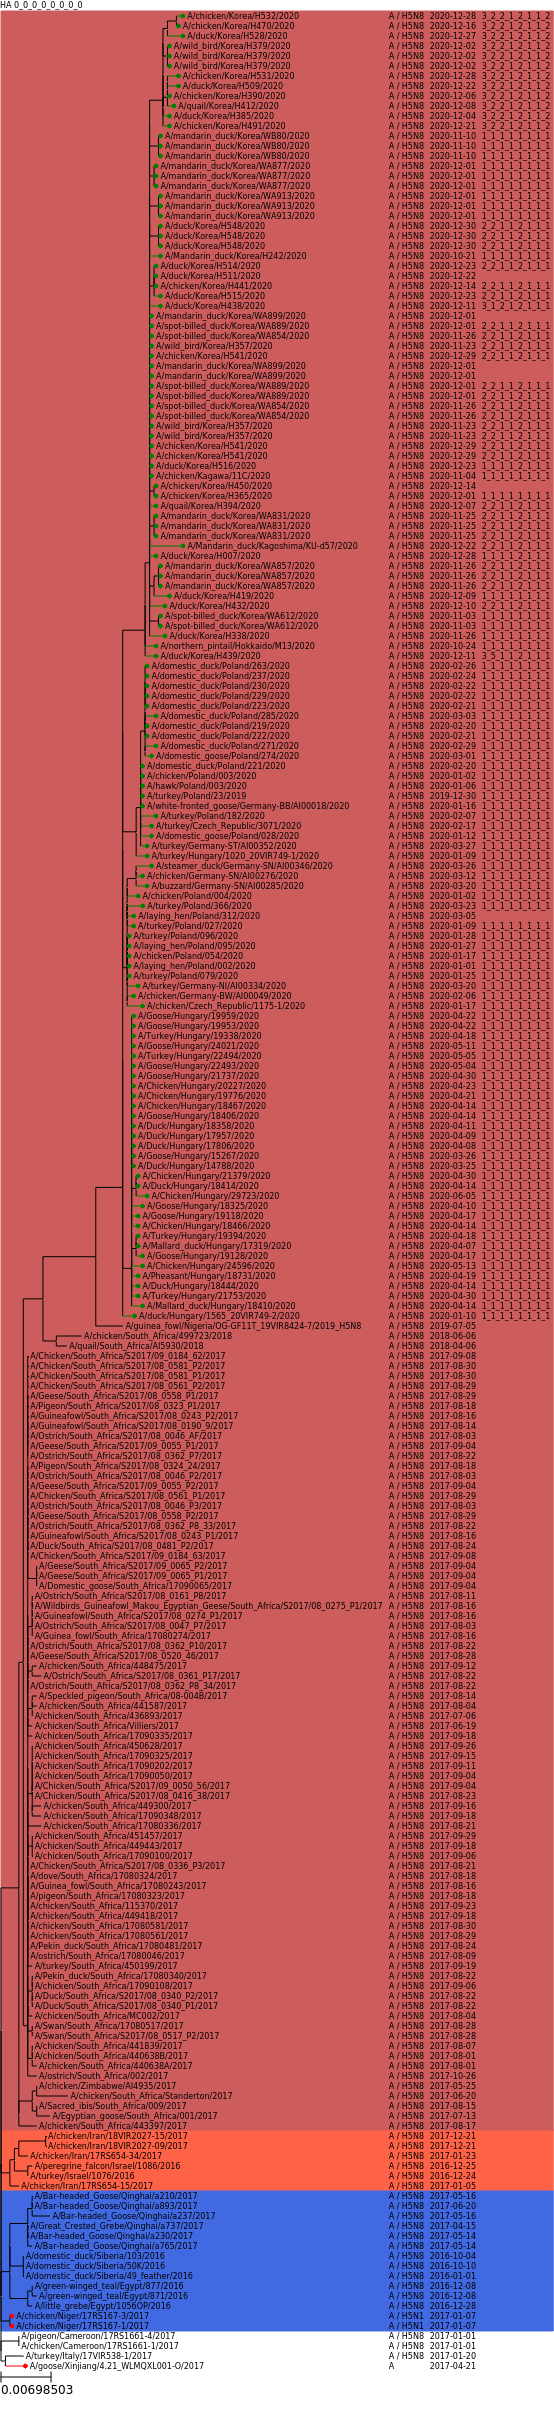

In [55]:
# domain_group = ['1_1_1_1_1_1_1_1', '0_0_0_0_0_0_0_0', '4_2_3_0_3_2_0_0', '2_2_1_1_2_1_1_1', '3_2_2_1_2_1_1_2', '1_1_1_1_2_1_1_1']

SEGMENT = 'MP'
# group = domain_group[1]
tree = parse_blast_tree(SEGMENT)

# acc_l = genotype.query('group == @group').index.tolist()
acc_l = acc_southafrica
leaf_filter = [leaf for leaf in tree.iter_leaves() if leaf.name in acc_l]

mrca = tree.get_common_ancestor(leaf_filter)
# set color
mrca.img_style['bgcolor'] = 'IndianRed'
sis = mrca.get_sisters()[0]
sis.img_style['bgcolor'] = 'Tomato'
outgroup = mrca.up.get_sisters()[0]
outgroup.img_style['bgcolor'] = 'RoyalBlue'
subtree = outgroup.up.up
# subtree = sis.up


ts = TreeStyle()
# ts.mode = "c"
# ts.arc_start = -180 # 0 degrees = 3 o'clock
# ts.arc_span = 180

ts.show_leaf_name = False
ts.title.add_face(TextFace(f"{SEGMENT} {group}", fsize=6), column=0, )

subtree.render("%%inline", tree_style=ts, layout=layout2, dpi=100)

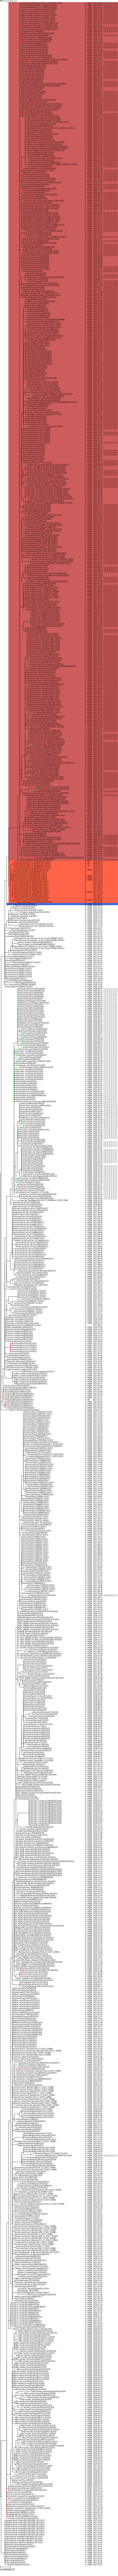

In [56]:
domain_group = ['1_1_1_1_1_1_1_1', '0_0_0_0_0_0_0_0', '4_2_3_0_3_2_0_0', '2_2_1_1_2_1_1_1', '3_2_2_1_2_1_1_2', '1_1_1_1_2_1_1_1']

SEGMENT = 'MP'
group = domain_group[1]
tree = parse_blast_tree(SEGMENT)

acc_l = genotype.query('group == @group').index.tolist()
leaf_filter = [leaf for leaf in tree.iter_leaves() if leaf.name in acc_l]

mrca = tree.get_common_ancestor(leaf_filter)
# set color
mrca.img_style['bgcolor'] = 'IndianRed'
sis = mrca.get_sisters()[0]
sis.img_style['bgcolor'] = 'Tomato'
outgroup = mrca.up.get_sisters()[0]
outgroup.img_style['bgcolor'] = 'RoyalBlue'
subtree = outgroup.up.up.up.up.up
# subtree = sis.up


ts = TreeStyle()
# ts.mode = "c"
# ts.arc_start = -180 # 0 degrees = 3 o'clock
# ts.arc_span = 180

ts.show_leaf_name = False
ts.title.add_face(TextFace(f"{SEGMENT} {group}", fsize=6), column=0, )

subtree.render("%%inline", tree_style=ts, layout=layout2, dpi=100)

In [65]:
t_acc = subtree.get_leaf_names()
#! extract ext metainfo
meta_info_keep = AIV_INFO[AIV_INFO.index.isin(t_acc)]
meta_info_keep = meta_info_keep.loc[meta_info_keep.index.drop_duplicates(keep='first'), :].copy()[['Isolate_Name', 'Subtype', 'Host', 'Location', 'Collection_Date', 'Domestic_Status']]
meta_info_keep

,Isolate_Name,Subtype,Host,Location,Collection_Date,Domestic_Status
Isolate_Id,,,,,,
EPI_ISL_525462,A/domestic_goose/Poland/274/2020,A / H5N8,Goose,Europe / Poland,2020-03-01,NaN
EPI_ISL_525442,A/turkey/Poland/027/2020,A / H5N8,Turkey,Europe / Poland,2020-01-09,NaN
EPI_ISL_525445,A/turkey/Poland/079/2020,A / H5N8,Turkey,Europe / Poland,2020-01-25,NaN
EPI_ISL_525447,A/turkey/Poland/096/2020,A / H5N8,Turkey,Europe / Poland,2020-01-28,NaN
EPI_ISL_525448,A/turkey/Poland/182/2020,A / H5N8,Turkey,Europe / Poland,2020-02-07,NaN
...,...,...,...,...,...,...
EPI_ISL_292476,A/Bar-headed Goose/Qinghai/a237/2017,A / H5N8,Anser indicus,Asia / China / Qinghai Province,2017-05-16,Wild
EPI_ISL_292341,A/Bar-headed Goose/Qinghai/a218/2017,A / H5N8,Anser indicus,Asia / China / Qinghai Province,2017-05-16,Wild
EPI_ISL_292340,A/Bar-headed Goose/Qinghai/a230/2017,A / H5N8,Anser indicus,Asia / China / Qinghai Province,2017-05-14,Wild


In [66]:
q_records = []
records = list(SeqIO.parse(f'./data/02_align_unified/db1_seq_by_acc_{SEGMENT}.fasta', 'fasta'))
for record in records:
    acc, data = record.id.split('|')
    record.id = acc
    record.name = ''
    record.description = ''
    record.seq = record.seq.upper()
    if acc in t_acc:
        q_records.append(record)

SeqIO.write(q_records, 'tmp_query.fasta', 'fasta')


ext_acc = [acc for acc in t_acc if acc not in acc_with_full_genome]
seg_acc_l = AIV_INFO.loc[ext_acc, '%s Segment_Id' % SEGMENT].to_list()

# ! extract ext sequences
blastdbcmd = subprocess.run(
    'blastdbcmd -db fludb/fludb2 -entry_batch -',
    shell=True,
    universal_newlines=True,
    input="\n".join(seg_acc_l),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    env={'PATH':'/home/zeng/opt/ncbi-blast-2.11.0+/bin/'}
)

stdout = blastdbcmd.stdout
records = list(SeqIO.parse(StringIO(stdout), 'fasta'))
records_de = []
acc_have = []
for record in records:
    isl_acc = record.description.split('#')[1]
    record.id = isl_acc
    record.name = ''
    record.description = ''
    if isl_acc not in acc_have:
        records_de.append(record)
        acc_have.append(isl_acc)

SeqIO.write(records_de, 'tmp_subject.fasta', 'fasta')

mafft_client = subprocess.run(
    f'mafft --6merpair --keeplength --addfragments tmp_subject.fasta tmp_query.fasta > ext_{group}_{SEGMENT}.fasta',
    shell=True
)

os.remove('tmp_query.fasta')
os.remove('tmp_subject.fasta')

In [67]:
records = SeqIO.to_dict(SeqIO.parse(f'ext_{group}_{SEGMENT}.fasta', 'fasta'))

meta_info_keep.loc[:, 'status'] = meta_info_keep.index.map(lambda x: "Q" if x in acc_with_full_genome else "S")
meta_info_keep.loc[:, 'seq'] = meta_info_keep.index.map(lambda x: str(records[x].seq))

meta_info_keep = meta_info_keep.sort_values(by=['status', 'Collection_Date'])
# meta_info_keep = meta_info_keep.groupby(['status'], group_keys=False).apply(lambda d: d.drop_duplicates(subset=('seq'), keep='first')).copy()
meta_info_keep = meta_info_keep.drop_duplicates(subset=('seq'), keep='first').copy()
meta_info_keep.head()

,Isolate_Name,Subtype,Host,Location,Collection_Date,Domestic_Status,status,seq
Isolate_Id,,,,,,,,
EPI_ISL_402134,A/turkey/Poland/23/2019,A / H5N8,Meleagris gallopavo,Europe / Poland / Lublin Voivodeship,2019-12-30,Domestic,Q,atgaatccaaatcagaaaatagtgaccgttggctccatttcattag...
EPI_ISL_525439,A/laying_hen/Poland/002/2020,A / H5N8,Gallus gallus domesticus,Europe / Poland / Greater Poland Voivodeship,2020-01-01,Domestic,Q,atgaatccaaatcagaaaatagtgaccgttggctccatttcattag...
EPI_ISL_525441,A/chicken/Poland/004/2020,A / H5N8,Gallus gallus domesticus,Europe / Poland / Lublin Voivodeship,2020-01-02,Domestic,Q,atgaatccaaatcagaaaatagtgaccgttggctccatttcattag...
EPI_ISL_405813,A/hawk/Poland/003/2020,A / H5N8,Wild bird,Europe / Poland / Lublin Voivodeship,2020-01-06,Wild,Q,atgaatccaaatcagaaaatagtgaccgttggctccatttcattag...
EPI_ISL_525442,A/turkey/Poland/027/2020,A / H5N8,Turkey,Europe / Poland,2020-01-09,NaN,Q,atgaatccaaatcagaaaatagtgaccgttggctccatttcattag...


In [68]:
records = [SeqRecord(id=k, name='', description='', seq=Seq(v)) for k, v in meta_info_keep['seq'].iteritems()]
SeqIO.write(records, f'ext_{group}_{SEGMENT}.fasta', 'fasta')
meta_info_keep[['Isolate_Name', 'Subtype', 'Host', 'Location', 'Collection_Date', 'Domestic_Status']].to_csv(f'ext_{group}_{SEGMENT}.csv', sep='\t')

print(f'{len(records)} sequences in extend dataset for {SEGMENT}')
print(f'{meta_info_keep.shape[0]} metainfo records')

meta_info_keep.status.value_counts()

150 sequences in extend dataset for NA
150 metainfo records


S    77
Q    73
Name: status, dtype: int64

## Merge and unify extend data

In [184]:
file_l = glob.glob('ext_*.csv')
file_l


['ext_1_1_1_1_1_1_1_1_NP.csv',
 'ext_1_1_1_1_1_1_1_1_PB2.csv',
 'ext_1_1_1_1_1_1_1_1_HA.csv',
 'ext_0_0_0_0_0_0_0_0_HA.csv',
 'ext_0_0_0_0_0_0_0_0_NP.csv',
 'ext_1_1_1_1_1_1_1_1_NS.csv',
 'ext_0_0_0_0_0_0_0_0_PB1.csv',
 'ext_0_0_0_0_0_0_0_0_PB2.csv',
 'ext_1_1_1_1_1_1_1_1_PB1.csv',
 'ext_0_0_0_0_0_0_0_0_MP.csv',
 'ext_1_1_1_1_1_1_1_1_PA.csv',
 'ext_0_0_0_0_0_0_0_0_NS.csv',
 'ext_1_1_1_1_1_1_1_1_MP.csv',
 'ext_0_0_0_0_0_0_0_0_NA.csv',
 'ext_1_1_1_1_1_1_1_1_NA.csv',
 'ext_0_0_0_0_0_0_0_0_PA.csv']

In [188]:
ext_df_l = [pd.read_csv(file, sep='\t') for file in file_l]
ext_df = pd.concat(ext_df_l, ignore_index=True)
ext_df = ext_df.drop_duplicates(subset=['Isolate_Id']).copy()
print(ext_df.shape)
ext_df.head()

(875, 7)


,Isolate_Id,Isolate_Name,Subtype,Host,Location,Collection_Date,Domestic_Status
0,EPI_ISL_402134,A/turkey/Poland/23/2019,A / H5N8,Meleagris gallopavo,Europe / Poland / Lublin Voivodeship,2019-12-30,Domestic
1,EPI_ISL_525439,A/laying_hen/Poland/002/2020,A / H5N8,Gallus gallus domesticus,Europe / Poland / Greater Poland Voivodeship,2020-01-01,Domestic
2,EPI_ISL_525440,A/chicken/Poland/003/2020,A / H5N8,Gallus gallus domesticus,Europe / Poland / Lublin Voivodeship,2020-01-02,Domestic
3,EPI_ISL_525441,A/chicken/Poland/004/2020,A / H5N8,Gallus gallus domesticus,Europe / Poland / Lublin Voivodeship,2020-01-02,Domestic
4,EPI_ISL_405813,A/hawk/Poland/003/2020,A / H5N8,Wild bird,Europe / Poland / Lublin Voivodeship,2020-01-06,Wild


In [186]:
def annotate_host_loc(ext_df):
    ext_df['host'] = ext_df['Isolate_Name'].str.split('/').str.get(1)
    ext_df['Region'] = ext_df['Location'].str.split(' / ').str.get(0)
    ext_df['Country'] = ext_df['Location'].str.split(' / ').str.get(1)
    ext_df['Province'] = ext_df['Location'].str.split(' / ').str.get(2)

    loc_info = pd.read_csv('./data/code_location.csv', sep='\t')
    host_info = pd.read_csv('./data/code_host.csv', sep='\t')

    ext_df_with_loc = pd.merge(ext_df, loc_info, on=['Region', 'Country', 'Province'], how='left')
    ext_df_with_loc_host = pd.merge(ext_df_with_loc, host_info, on=['Host', 'host'], how='left')
    return ext_df_with_loc_host

In [190]:
tmp = annotate_host_loc(ext_df)
tmp

,Isolate_Id,Isolate_Name,Subtype,Host,Location,Collection_Date,Domestic_Status,host,Region,Country,Province,Subregion,Latitude,Longitude,host2
0,EPI_ISL_402134,A/turkey/Poland/23/2019,A / H5N8,Meleagris gallopavo,Europe / Poland / Lublin Voivodeship,2019-12-30,Domestic,turkey,Europe,Poland,Lublin Voivodeship,Central_East_Europe,51.25,23.10,Dom-gal
1,EPI_ISL_525439,A/laying_hen/Poland/002/2020,A / H5N8,Gallus gallus domesticus,Europe / Poland / Greater Poland Voivodeship,2020-01-01,Domestic,laying_hen,Europe,Poland,Greater Poland Voivodeship,Central_East_Europe,52.28,17.35,Dom-gal
2,EPI_ISL_525440,A/chicken/Poland/003/2020,A / H5N8,Gallus gallus domesticus,Europe / Poland / Lublin Voivodeship,2020-01-02,Domestic,chicken,Europe,Poland,Lublin Voivodeship,Central_East_Europe,51.25,23.10,Dom-gal
3,EPI_ISL_525441,A/chicken/Poland/004/2020,A / H5N8,Gallus gallus domesticus,Europe / Poland / Lublin Voivodeship,2020-01-02,Domestic,chicken,Europe,Poland,Lublin Voivodeship,Central_East_Europe,51.25,23.10,Dom-gal
4,EPI_ISL_405813,A/hawk/Poland/003/2020,A / H5N8,Wild bird,Europe / Poland / Lublin Voivodeship,2020-01-06,Wild,hawk,Europe,Poland,Lublin Voivodeship,Central_East_Europe,51.25,23.10,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,EPI_ISL_1114751,A/turkey/Stavropol/320-03/2020,A / H5N8,Meleagris gallopavo,Europe / Russian Federation / Stavropol Krai /...,2020-12-11,NaN,turkey,Europe,Russian Federation,Stavropol Krai,East_Europe,44.67,43.52,Dom-gal
871,EPI_ISL_1009692,A/duck/Korea/H010/2021,A / H5N8,Avian,"Asia / Korea, Republic of / CB",2021-01-05,NaN,duck,Asia,"Korea, Republic of",CB,East_Asia,36.80,127.70,Dom-ans
872,EPI_ISL_3135931,A/swan/Hungary/9638/2021 (H5N8),A / H5N8,Cygnus olor,Europe / Hungary / Csongrad megye,2021-03-08,Wild,swan,Europe,Hungary,Csongrad megye,Central_East_Europe,46.42,20.26,Waterfowl
873,EPI_ISL_505413,A/chicken/Albehra/18319F/2018,A / H5N8,Chicken,Africa / Egypt,2018-04,NaN,chicken,Africa,Egypt,NaN,South_East_Africa,26.82,30.80,Dom-gal


In [191]:
tmp.to_csv('dataset2_metainfo2.csv', sep='\t', index=False)

In [194]:
c = ['2016', '2017']
tmp.query('Collection_Date in @c')

,Isolate_Id,Isolate_Name,Subtype,Host,Location,Collection_Date,Domestic_Status,host,Region,Country,Province,Subregion,Latitude,Longitude,host2
465,EPI_ISL_285621,A/chicken/Egypt/Gharbiya-15/2017,A / H5N8,Chicken,Africa / Egypt / Gharbiya,2017,NaN,chicken,Africa,Egypt,Gharbiya,South_East_Africa,30.88,31.03,Dom-gal
600,EPI_ISL_885149,A/Grey-Headed Gull/Uganda/200144/2017,A / H5N8,Gull,Africa / Uganda,2017,NaN,Grey-Headed Gull,Africa,Uganda,NaN,East_Africa,1.37,23.29,Seabird
601,EPI_ISL_285620,A/chicken/Egypt/Buheira-12/2017,A / H5N8,Chicken,Africa / Egypt / Buheira,2017,NaN,chicken,Africa,Egypt,Buheira,South_East_Africa,30.85,30.34,Dom-gal
602,EPI_ISL_285622,A/duck/Egypt/Buheira-21/2017,A / H5N8,Chicken,Africa / Egypt / Buheira,2017,NaN,duck,Africa,Egypt,Buheira,South_East_Africa,30.85,30.34,Dom-ans
660,EPI_ISL_486440,recombinant A/tufted duck/Germany/AR8444/2016,A / H5N8,Avian,Europe / Germany,2016,NaN,tufted duck,Europe,Germany,NaN,West_Europe,51.17,10.45,Waterfowl
712,EPI_ISL_285619,A/chicken/Egypt/Kafr-Elshiekh-18/2017,A / H5N8,Duck,Africa / Egypt / Kafr-Elshiekh,2017,NaN,chicken,Africa,Egypt,Kafr-Elshiekh,South_East_Africa,31.11,30.94,Dom-gal


In [794]:
ext_metainfo = pd.read_csv('dataset2_metainfo4.csv', sep='\t')
ext_metainfo

,Isolate_Id,Isolate_Name,Subtype,Host,Location,Collection_Date,Domestic_Status,host,Region,Country,Province,Subregion,Latitude,Longitude,host2
0,EPI_ISL_637098,A/duck/Chelyabinsk/1207-1/2020,A / H5N8,Duck,Europe / Russian Federation / Chelyabinsk Oblast,2020-07-31,Domestic,duck,Europe,Russian Federation,Chelyabinsk Oblast,East_Europe,54.43,60.88,Dom-ans
1,EPI_ISL_644145,A/chicken/Chelyabinsk/401/2020,A / H5N8,Gallus gallus domesticus,Europe / Russian Federation / Chelyabinsk Obla...,2020-08-06,Domestic,chicken,Europe,Russian Federation,Chelyabinsk Oblast,East_Europe,54.43,60.88,Dom-gal
2,EPI_ISL_644122,A/goose/Omsk/0002/2020,A / H5N8,Anser anser domesticus,Europe / Russian Federation / Omsk Oblast / Om...,2020-08-13,Domestic,goose,Europe,Russian Federation,Omsk Oblast,North_Asia,55.06,73.72,Dom-ans
3,EPI_ISL_644124,A/duck/Omsk/0004/2020,A / H5N8,Anas platyrhynchos f. domestica,Europe / Russian Federation / Omsk Oblast / Omsk,2020-08-13,Domestic,duck,Europe,Russian Federation,Omsk Oblast,North_Asia,55.06,73.72,Dom-ans
4,EPI_ISL_644123,A/turkey/Omsk/0003/2020,A / H5N8,Meleagris gallopavo,Europe / Russian Federation / Omsk Oblast / Omsk,2020-08-13,Domestic,turkey,Europe,Russian Federation,Omsk Oblast,North_Asia,55.06,73.72,Dom-gal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,EPI_ISL_285945,A/Ostrich/South_Africa/S2017/08_0361_P12/2017,A / H5N8,Ostrich,Africa / South Africa / Province of the Wester...,2017-08-22,NaN,Ostrich,Africa,South Africa,Province of the Western Cape,South_Africa,-33.23,21.86,Other
941,EPI_ISL_285607,A/Duck/South_Africa/S2017/08_0340_P2/2017,A / H5N8,Duck,Africa / South Africa / Province of the Wester...,2017-08-22,NaN,Duck,Africa,South Africa,Province of the Western Cape,South_Africa,-33.23,21.86,Dom-ans
942,EPI_ISL_285937,A/Ostrich/South_Africa/S2017/08_0484_P1/2017,A / H5N8,Ostrich,Africa / South Africa / Province of the Wester...,2017-08-24,NaN,Ostrich,Africa,South Africa,Province of the Western Cape,South_Africa,-33.23,21.86,Other
943,EPI_ISL_285947,A/Ostrich/South_Africa/S2017/08_0484_P2/2017,A / H5N8,Ostrich,Africa / South Africa / Province of the Wester...,2017-08-24,NaN,Ostrich,Africa,South Africa,Province of the Western Cape,South_Africa,-33.23,21.86,Other


In [273]:
ext_metainfo[['Isolate_Id', 'Collection_Date']].to_csv('date.csv', index=False, sep='\t')

In [797]:
ext_metainfo[['Isolate_Id', 'Collection_Date']].to_csv('date2.tsv', sep='\t', index=False)

In [801]:
AIV_INFO.loc[["EPI_ISL_486440", "EPI_ISL_285621", "EPI_ISL_285619"], :]

,Isolate_Name,Subtype,Host,Location,Collection_Date,Domestic_Status,year,month,day,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id
Isolate_Id,,,,,,,,,,,,,,,,,
EPI_ISL_486440,recombinant A/tufted duck/Germany/AR8444/2016,A / H5N8,Avian,Europe / Germany,2016,NaN,2016,NaN,NaN,EPI1753772,EPI1753773,EPI1753771,EPI1753775,EPI1753768,EPI1753774,EPI1753770,EPI1753769
EPI_ISL_285621,A/chicken/Egypt/Gharbiya-15/2017,A / H5N8,Chicken,Africa / Egypt / Gharbiya,2017,NaN,2017,NaN,NaN,EPI1104288,EPI1104289,EPI1104287,EPI1104291,EPI1104284,EPI1104290,EPI1104286,EPI1104285
EPI_ISL_285619,A/chicken/Egypt/Kafr-Elshiekh-18/2017,A / H5N8,Duck,Africa / Egypt / Kafr-Elshiekh,2017,NaN,2017,NaN,NaN,EPI1104272,EPI1104273,EPI1104271,EPI1104275,EPI1104268,EPI1104274,EPI1104270,EPI1104269
